# 1. Autores

<div style="display: flex; justify-content: center;">
  <table style="margin: auto; border-spacing: 60px;">
    <tr>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/PedroSampaioDias">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/90795603?v=4" width="150px;"/>
          <h5 class="text-center">Pedro Sampaio - 211043745</h5>
        </a>
      </td>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/raulbreno">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/72105072?v=4" width="150px;"/>
          <h5 class="text-center">Raul Breno - 200026810</h5>
        </a>
      </td>
    </tr>
  </table>
</div>


# 2. Abstract

# 3. Keywords

# 4. Introdução

O cerrado brasileiro possui uma grande diversidade de aves. Algumas delas apresentam um desenvolvimento cerebral maior que outras, como é o caso das aves da família Psittacidae. Diversas aves dessa família são conhecidas como papagaios, araras e periquitos.bEssas aves possuem inteligência superior em comparação às demais, sendo capazes de imitar diferentes sons. Caracterizam-se por um bico alto e curvo, com a parte superior maior que a inferior, além de apresentarem plumagens muito coloridas. Embora sejam bastante bonitas, podem ser difíceis de diferenciar a olho nu por pessoas que não possuem certas especializações. Com o objetivo de facilitar esse processo, a presente rede convolucional tem como finalidade analisar e identificar a espécie da ave a partir de uma imagem.

Para isso, será criada e treinada uma rede convolucional utilizando um conjunto de dados com mais de 3.000 imagens, obtidas a partir do site iNaturalist. O dataset possui diferentes quantidades de imagens para cada espécie e, a fim de equilibrar as classes, serão adicionadas novas imagens, além da aplicação de técnicas de data augmentation.

As especies a serem utilizadas no treinamento serão:

*   Amazona aestiva
*   Amazona amazonica
*   Anodorhynchus hyacinthinus
*   Ara ararauna
*   Ara chloropterus
*   Ara macao
*   Brotogeris chiriri
*   Diopsittaca nobilis
*   Eupsittula aurea
*   Forpus xanthopterygius
*   Orthopsittaca manilatus
*   Primolius maracana
*   Psittacara leucophthalmus
*   Touit melanonotus

Uma rede convolucional funciona a partir de três camadas principais: a camada convolucional, a camada de agrupamento e a camada totalmente conectada. A camada convolucional tem como objetivo dividir a imagem em regiões e aplicar filtros a partir de pesos aprendidos. A camada de agrupamento aplica um filtro sem pesos de treinamento na entrada, a fim de reduzir a quantidade de informações, mantendo apenas as mais relevantes. Por fim, a camada totalmente conectada realiza a classificação e retorna ao usuário a informação final.

A fim de comparar a rede criada, também será realizado o transfer learning a partir de uma arquitetura já consolidada, seguido do fine-tuning. Dessa forma, o resultado final compreenderá três redes convolucionais. A arquitetura utilizada para criar a rede convolucional será a ResNet50; para o transfer learning será empregada a XXXX; e, para o fine-tuning, será aplicada a técnica XXXX.

# 5. Trabalhos Relacionados

# 6. Metodologia

## 6.1 Imports

Esta célula faz o import das bibliotecas que serão utilizadas no notebook.


In [1]:
import gdown
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
from fractions import Fraction
import random
import shutil
import cv2
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, CoarseDropout

## 6.2 Download do dataset original

Nesta etapa realizamos o processo completo de obtenção e organização do conjunto de dados.  
O arquivo compactado é baixado do Google Drive por meio da biblioteca **gdown**, armazenado em uma pasta de arquivos **compactados** e, em seguida, descompactado para a pasta **dataset_original**. Após a extração, diretórios e arquivos temporários do sistema (como `__MACOSX` e `.DS_Store`) são removidos, garantindo uma estrutura limpa e padronizada.  

Ao final, temos um dataset pronto para uso, organizado em `datasets/` e pronto para os próximos passos.


In [2]:
file_id = "19rWCGW38ht8TLY1ad7gba46mP5FCIZul"
url = f"https://drive.google.com/uc?id={file_id}"
zip_name = "dataset_original.zip"

base = Path("datasets"); compact = base/"compactados"; extract = base/"dataset_original"
base.mkdir(exist_ok=True); compact.mkdir(parents=True, exist_ok=True); extract.mkdir(parents=True, exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".tiff",".tif",".webp"}
contar_imgs = lambda p: sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

def pronto(p):
    return p.exists() and sum(1 for d in p.iterdir() if d.is_dir()) == 14 and contar_imgs(p) == 2879

if pronto(extract):
    print("✅ Dataset já existe.")
else:
    print("📥 Baixando..."); gdown.download(url, zip_name, quiet=False)
    dest = compact/zip_name; dest.unlink(missing_ok=True); shutil.move(zip_name, dest)
    print("📂 Extraindo..."); zipfile.ZipFile(dest).extractall(extract)
    [shutil.rmtree(d, ignore_errors=True) for d in extract.rglob("__MACOSX")]
    [f.unlink(missing_ok=True) for f in extract.rglob(".DS_Store")]
    print(f"📸 Total de imagens: {contar_imgs(extract)}")
    print("✅ Dataset pronto em:", base.resolve())


📥 Baixando...


Downloading...
From (original): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul
From (redirected): https://drive.google.com/uc?id=19rWCGW38ht8TLY1ad7gba46mP5FCIZul&confirm=t&uuid=19791ed9-b8f7-4ea9-a8fb-939f44b3cd2c
To: /content/dataset_original.zip
100%|██████████| 277M/277M [00:04<00:00, 61.4MB/s]


📂 Extraindo...
📸 Total de imagens: 2879
✅ Dataset pronto em: /content/datasets


## 6.3 Exploração de dados

### 6.3.1 Organização do dataset

In [3]:
dataset_path = "./datasets/dataset_original"

#### 6.3.1.1 Quantidade total de imagens

In [4]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
total_images

2879

#### 6.3.1.2 Número de classes (espécies)

In [5]:
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_classes = len(classes)
num_classes

14

### 6.3.2 Distribuição das classes

#### 6.3.2.1 Frequência de imagens por classe com representação em quantidade e porcentagem

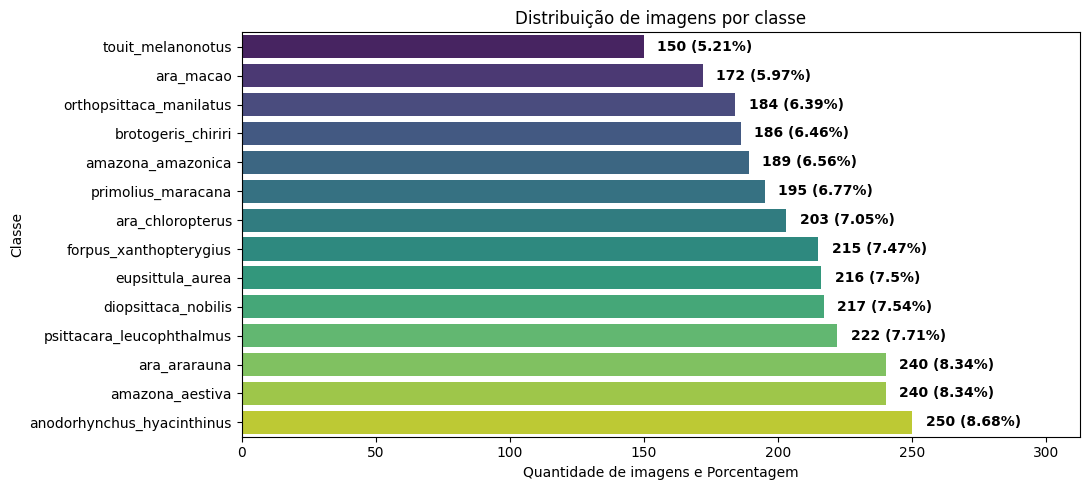

In [6]:
df = pd.DataFrame([
    (c, sum(1 for _,_,fs in os.walk(os.path.join(dataset_path, c))
            for f in fs if os.path.splitext(f)[1].lower() in exts))
    for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))
], columns=["classe","imagens"]).sort_values("imagens")

df["pct"] = (df["imagens"] / df["imagens"].sum() * 100).round(2)

plt.figure(figsize=(11,5))
ax = sns.barplot(data=df, x="imagens", y="classe",
                 hue="classe", dodge=False, palette="viridis",
                 orient="h", legend=False)

for i, p in enumerate(ax.patches):
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2,
            f"{int(p.get_width())} ({df['pct'].iloc[i]}%)",
            va="center", ha="left", weight="bold")

max_val = df["imagens"].max()
ax.set_xlim(0, max_val * 1.25)

ax.set(title="Distribuição de imagens por classe",
       xlabel="Quantidade de imagens e Porcentagem", ylabel="Classe")

plt.tight_layout()
plt.show()


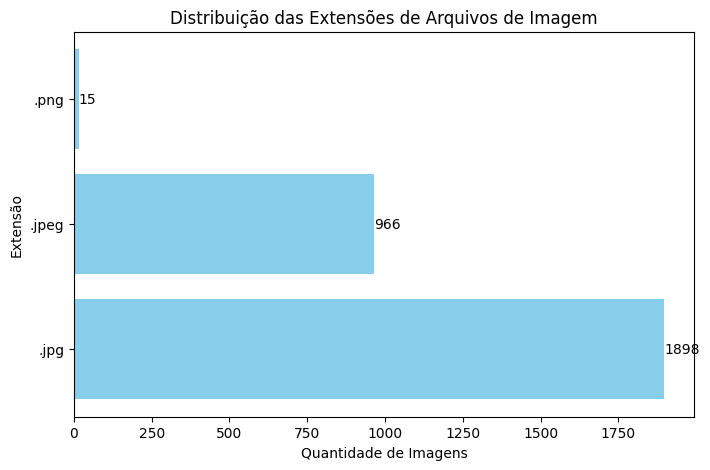

In [7]:
extensoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:  # garante que tem extensão
            extensoes.append(ext)

# Conta as ocorrências de cada extensão
contagem = Counter(extensoes)

# Separa chaves e valores
extensoes_unicas = list(contagem.keys())
quantidades = list(contagem.values())

# Cria gráfico de barras horizontal
plt.figure(figsize=(8,5))
bars = plt.barh(extensoes_unicas, quantidades, color="skyblue")
plt.xlabel("Quantidade de Imagens")
plt.ylabel("Extensão")
plt.title("Distribuição das Extensões de Arquivos de Imagem")

# Adiciona os valores na frente das barras
for bar, qtd in zip(bars, quantidades):
    plt.text(qtd + 0.5, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center")

plt.show()

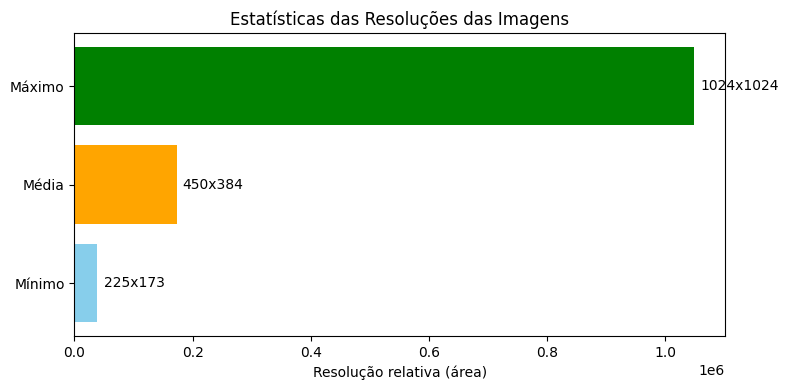

In [8]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append((w, h))
            except:
                pass

# Estatísticas
larguras = [w for w, h in resolucoes]
alturas = [h for w, h in resolucoes]

res_min = (min(larguras), min(alturas))
res_max = (max(larguras), max(alturas))
res_media = (int(np.mean(larguras)), int(np.mean(alturas)))

# Lista de barras com valores e rótulos
barras = [
    ("Mínimo", res_min),
    ("Média", res_media),
    ("Máximo", res_max)
]

# Ordena por largura*altura (área da imagem)
barras.sort(key=lambda x: x[1][0]*x[1][1])

# Extrai dados para plot
nomes = [nome for nome, res in barras]
res_labels = [f"{res[0]}x{res[1]}" for nome, res in barras]
valores = [res[0]*res[1] for nome, res in barras]  # usado só para tamanho da barra

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(range(len(nomes)), valores, color=["skyblue", "orange", "green"])
plt.yticks(range(len(nomes)), nomes)
plt.xlabel("Resolução relativa (área)")
plt.title("Estatísticas das Resoluções das Imagens")

# Adiciona rótulo [LxA] na frente de cada barra
for bar, label in zip(bars, res_labels):
    plt.text(bar.get_width() + max(valores)*0.01,
             bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

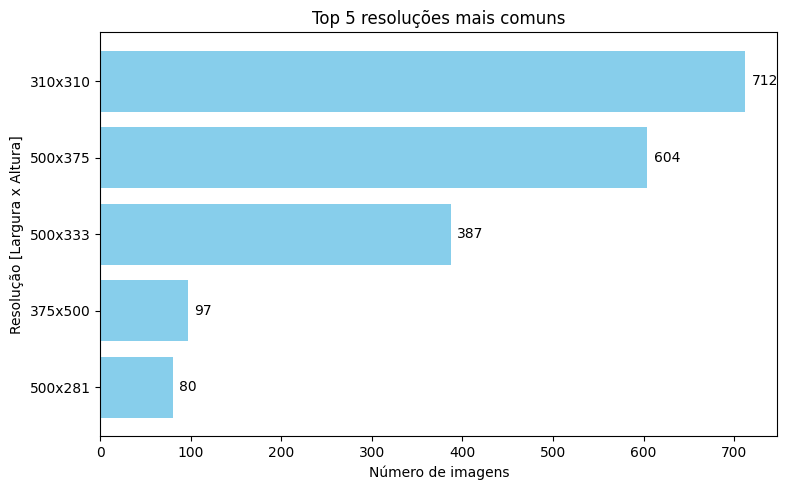

In [9]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append(f"{w}x{h}")  # guarda como string "LxA"
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada resolução
contagem = Counter(resolucoes)

# Pega as 5 resoluções mais comuns
top5 = contagem.most_common(5)  # retorna lista de tuplas: [(resolucao, quantidade), ...]

# Separa em listas para plot
resolucoes_top5 = [item[0] for item in top5]
quantidades_top5 = [item[1] for item in top5]

# Cria gráfico horizontal
plt.figure(figsize=(8,5))
# inverte listas para colocar a maior barra em cima
bars = plt.barh(resolucoes_top5[::-1], quantidades_top5[::-1], color="skyblue")
plt.xlabel("Número de imagens")
plt.ylabel("Resolução [Largura x Altura]")
plt.title("Top 5 resoluções mais comuns")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top5[::-1]):
    plt.text(qtd + max(quantidades_top5)*0.01,
             bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [10]:

# Número total de resoluções únicas
total_resolucoes = len(contagem)
print(f"Número total de resoluções únicas: {total_resolucoes}")

Número total de resoluções únicas: 361


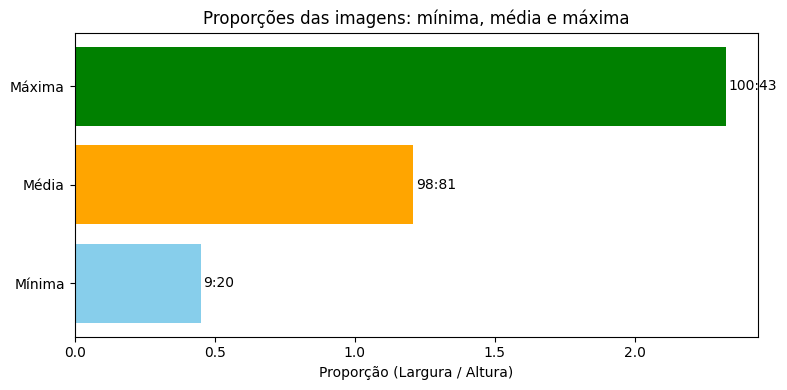

In [11]:
proporcoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    proporcao = Fraction(w, h).limit_denominator(100)  # simplifica a fração
                    proporcoes.append(proporcao)
            except:
                pass  # ignora arquivos corrompidos

# Calcula estatísticas
prop_min = min(proporcoes)
prop_max = max(proporcoes)
prop_media_decimal = np.mean([float(p) for p in proporcoes])
prop_media = Fraction(prop_media_decimal).limit_denominator(100)

# Lista para plot
barras = [
    ("Mínima", prop_min),
    ("Média", prop_media),
    ("Máxima", prop_max)
]

# Ordena por proporção decimal
barras.sort(key=lambda x: float(x[1]))

# Extrai dados para plot
nomes = [nome for nome, val in barras]
valores = [float(val) for nome, val in barras]
labels = [f"{val.numerator}:{val.denominator}" for nome, val in barras]  # rótulo L:A

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(nomes, valores, color=["skyblue", "orange", "green"])
plt.xlabel("Proporção (Largura / Altura)")
plt.title("Proporções das imagens: mínima, média e máxima")

# Adiciona rótulo L:A na frente da barra
for bar, label in zip(bars, labels):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

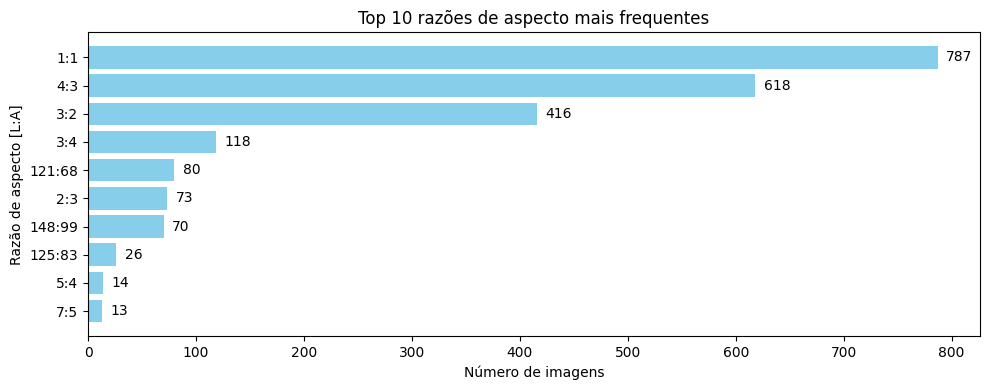

In [12]:
razoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    razao = Fraction(w, h).limit_denominator(100)
                    razoes.append(f"{razao.numerator}:{razao.denominator}")
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada razão
contagem = Counter(razoes)

# Pega as 10 razões mais frequentes
top10 = contagem.most_common(10)  # lista de tuplas: [(razao, quantidade), ...]

# Separa em listas para plot
razoes_top10 = [item[0] for item in top10]
quantidades_top10 = [item[1] for item in top10]

# Cria gráfico horizontal
plt.figure(figsize=(10, max(4, len(razoes_top10)*0.4)))
bars = plt.barh(razoes_top10[::-1], quantidades_top10[::-1], color="skyblue")  # inverte para a mais frequente em cima
plt.xlabel("Número de imagens")
plt.ylabel("Razão de aspecto [L:A]")
plt.title("Top 10 razões de aspecto mais frequentes")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top10[::-1]):
    plt.text(qtd + max(quantidades_top10)*0.01, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
"""dataset_final_path = "datasets/dataset_final"

# Número alvo de imagens por classe
target_count = 300

# Cria pasta final
if not os.path.exists(dataset_final_path):
    os.makedirs(dataset_final_path)

# Funções de data augmentation usando Albumentations
def get_random_augmentation():
    # Escolhe aleatoriamente uma transformação
    aug_type = random.choice(["rotate", "flip", "cutout"])
    if aug_type == "rotate":
        return Compose([Rotate(limit=(10, 340), p=1)])
    elif aug_type == "flip":
        # Aleatoriamente escolhe flip horizontal ou vertical
        if random.random() > 0.5:
            return Compose([HorizontalFlip(p=1)])
        else:
            return Compose([VerticalFlip(p=1)])
    elif aug_type == "cutout":
        return Compose([CoarseDropout(
            max_holes=3, min_holes=1,
            max_height=0.2, min_height=0.1,
            max_width=0.2, min_width=0.1,
            fill_value=0, p=1
        )])

# Percorre todas as classes
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_path):
        continue

    # Cria a pasta da classe no dataset final
    final_class_path = os.path.join(dataset_final_path, class_folder)
    os.makedirs(final_class_path, exist_ok=True)

    # Lista todas as imagens
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # Copia imagens originais para a pasta final
    for img_name in images:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(final_class_path, img_name))

    current_count = len(images)
    print(f"Classe '{class_folder}' tem {current_count} imagens. Processando...")

    # Gera imagens até atingir target_count
    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        # Carrega imagem com OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Aplica uma transformação aleatória
        aug = get_random_augmentation()
        augmented = aug(image=img)['image']

        # Salva imagem final
        save_name = f"aug_{current_count}.jpg"
        save_path = os.path.join(final_class_path, save_name)
        augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, augmented_bgr)

        current_count += 1

    print(f"Classe '{class_folder}' finalizada com {current_count} imagens.")

print("Data augmentation concluído. Dataset final criado em 'dataset_final'.")"""

Classe 'forpus_xanthopterygius' tem 215 imagens. Processando...


/tmp/ipython-input-2558984096.py:23: UserWarning: Argument(s) 'max_holes, min_holes, max_height, min_height, max_width, min_width, fill_value' are not valid for transform CoarseDropout
  return Compose([CoarseDropout(


Classe 'forpus_xanthopterygius' finalizada com 300 imagens.
Classe 'anodorhynchus_hyacinthinus' tem 250 imagens. Processando...
Classe 'anodorhynchus_hyacinthinus' finalizada com 300 imagens.
Classe 'touit_melanonotus' tem 150 imagens. Processando...
Classe 'touit_melanonotus' finalizada com 300 imagens.
Classe 'amazona_amazonica' tem 189 imagens. Processando...
Classe 'amazona_amazonica' finalizada com 300 imagens.
Classe 'eupsittula_aurea' tem 216 imagens. Processando...
Classe 'eupsittula_aurea' finalizada com 300 imagens.
Classe 'ara_ararauna' tem 240 imagens. Processando...
Classe 'ara_ararauna' finalizada com 300 imagens.
Classe 'ara_chloropterus' tem 203 imagens. Processando...
Classe 'ara_chloropterus' finalizada com 300 imagens.
Classe 'ara_macao' tem 172 imagens. Processando...
Classe 'ara_macao' finalizada com 300 imagens.
Classe 'amazona_aestiva' tem 240 imagens. Processando...
Classe 'amazona_aestiva' finalizada com 300 imagens.
Classe 'orthopsittaca_manilatus' tem 184 ima

In [15]:
!zip -r meus_arquivos.zip /content/datasets/dataset_final
from google.colab import files
files.download("meus_arquivos.zip")

  adding: content/datasets/dataset_final/ (stored 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_118.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_113.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_3.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_205.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_131.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_212.jpg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/forpus_xanthopterygius_168.jpeg (deflated 0%)
  adding: content/datasets/dataset_final/forpus_xanthopterygius/aug_270.jpg (deflated 2%)
  adding: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Trenamento

In [16]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [20]:
data_dir = "./datasets/dataset_final"

# Pastas de saída
train_dir = "./datasets/train_images"
test_dir = "./datasets/test_images"

# Criar as pastas de destino
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definir proporções
train_split = 0.8
test_split = 0.2

# Loop em cada subpasta (classe)
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Criar subpastas correspondentes em train/test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Listar imagens da classe
    images = os.listdir(class_path)
    random.shuffle(images)

    # Separar em 80% / 20%
    split_idx = int(len(images) * train_split)
    train_files = images[:split_idx]
    test_files = images[split_idx:]

    # Copiar arquivos
    for img in train_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))
    for img in test_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(test_dir, class_name, img))

print("✅ Divisão concluída!")

✅ Divisão concluída!


In [22]:
!zip -r testImage.zip /content/datasets/test_images
from google.colab import files
files.download("testImage.zip")

!zip -r trainImage.zip /content/datasets/train_images
from google.colab import files
files.download("trainImage.zip")

  adding: content/datasets/test_images/ (stored 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_205.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_140.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_193.jpeg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/aug_244.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_53.jpeg (deflated 1%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_215.jpeg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthopterygius/aug_256.jpg (deflated 2%)
  adding: content/datasets/test_images/forpus_xanthopterygius/forpus_xanthopterygius_158.jpg (deflated 0%)
  adding: content/datasets/test_images/forpus_xanthop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/datasets/train_images/ (stored 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/ (stored 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_118.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_113.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_3.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_131.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_212.jpg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_168.jpeg (deflated 0%)
  adding: content/datasets/train_images/forpus_xanthopterygius/aug_270.jpg (deflated 2%)
  adding: content/datasets/train_images/forpus_xanthopterygius/forpus_xanthopterygius_56.jpeg (deflated 0%)
  adding: content/dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


class_names = ['Amazona aestiva', 'Amazona amazonica', 'Anodorhynchus hyacinthinus', 'Ara ararauna', 'Ara chloropterus',
               'Ara macao', 'Brotogeris chiriri', 'Diopsittaca nobilis', 'Eupsittula aurea', 'Forpus xanthopterygius',
               'Orthopsittaca manilatus', 'Primolius maracana', 'Psittacara leucophthalmus', 'Touit melanonotus']



# Normalizando as imagens
train_images = train_images / 255
test_images = test_images / 255

# Codificação one-hot das etiquetas
num_classes = 14
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Criando um modelo sequência e adicionando camadas nele
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (32, 32, 3)

model = models.Sequential([
    # Bloco 1
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same', name='conv1_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv1_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 2
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv2_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloco 3
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_1'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', name='conv3_2'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Classificador
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=25,
                    validation_data=(test_images, test_labels))


In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

# Curva de acurácia
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

# Mostrando o verdadeiro vs. Resultado previsto

# Gera a matriz de confusão

# Calcular e exibir a matriz de confusão
cm_cifar = confusion_matrix(np.argmax(test_labels, axis=1), pred_classes)
disp_cifar = ConfusionMatrixDisplay(confusion_matrix=cm_cifar, display_labels=class_names)

# Usamos um tamanho de figura maior e rotação nos rótulos para melhor visualização
fig, ax = plt.subplots(figsize=(10, 10))
disp_cifar.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - CIFAR-10")
plt.xticks(rotation=45)
plt.show()

# 7. Resultados

# 8. Conclusão

# 9. Referências